# Parametric Experiment!
#### Studying the affects of batch size on model accuracy.
- Batch Size will be parametrically varied, while other meta parameters are held constant.
- Model accuracy will be recorded to evaluate model performance and gauge the affect that batch size had on the model.

In [405]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np
import scipy.stats as stats

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

In [406]:
# importing wine dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

data = pd.read_csv(url, sep=';')

#### Examining Dataset
- Will remove outliers and use Z-score normalization.

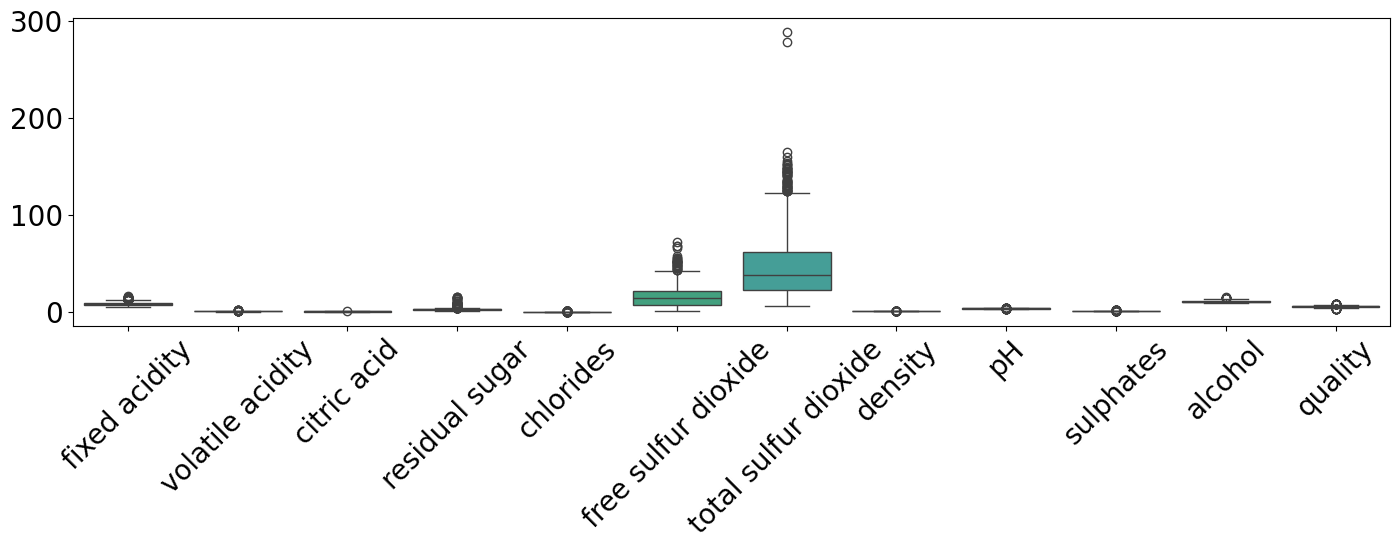

In [407]:
# plotting unmodified data
fig, ax = plt.subplots(1, figsize=(17,4))
ax = sns.boxplot(data=data)
ax.tick_params(axis='x', rotation=45)
plt.show()

#### Removing outliers in `total sulfur dioxide` feature

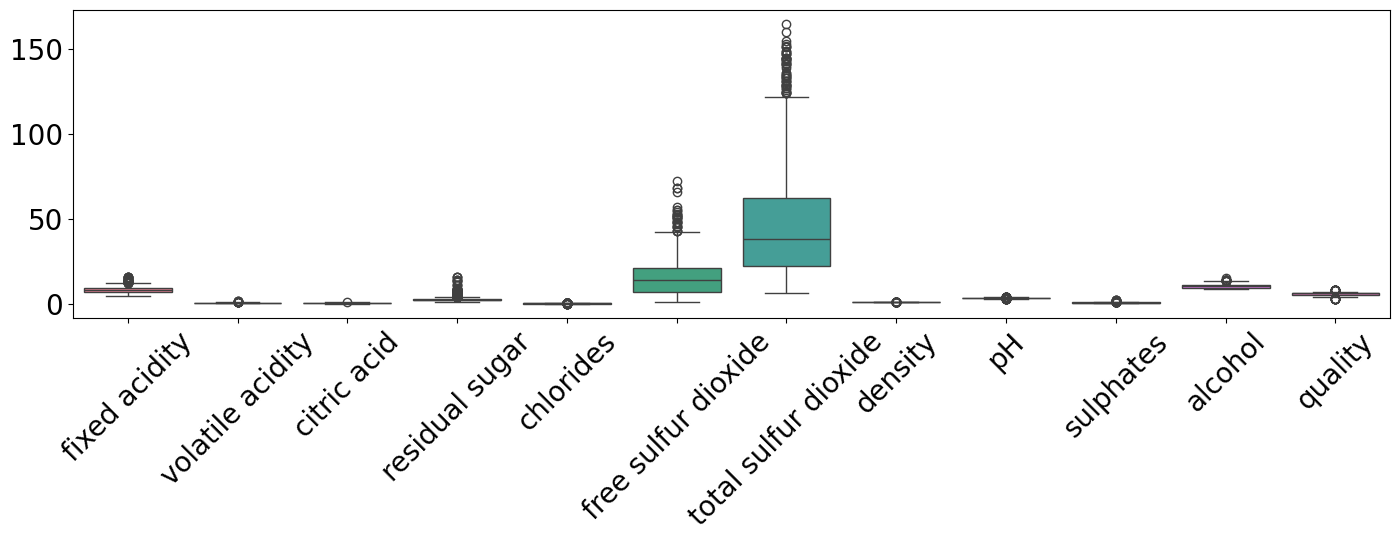

In [408]:
# removing outliers
data = data.drop(data[(data['total sulfur dioxide']>200)].index) # finds indices of rows where total sulfur dioxide > 200 and drops them

# plotting data before Z-score normalization
fig, ax = plt.subplots(1, figsize=(17,4))
ax = sns.boxplot(data=data)
ax.tick_params(axis='x', rotation=45)
plt.show()

#### Applying Z-score Normalization to all features except `quality`.

In [409]:
# selecting columns to normalize
selected_columns = data.keys()
selected_columns = selected_columns.drop('quality')

data[selected_columns] = data[selected_columns].apply(stats.zscore)

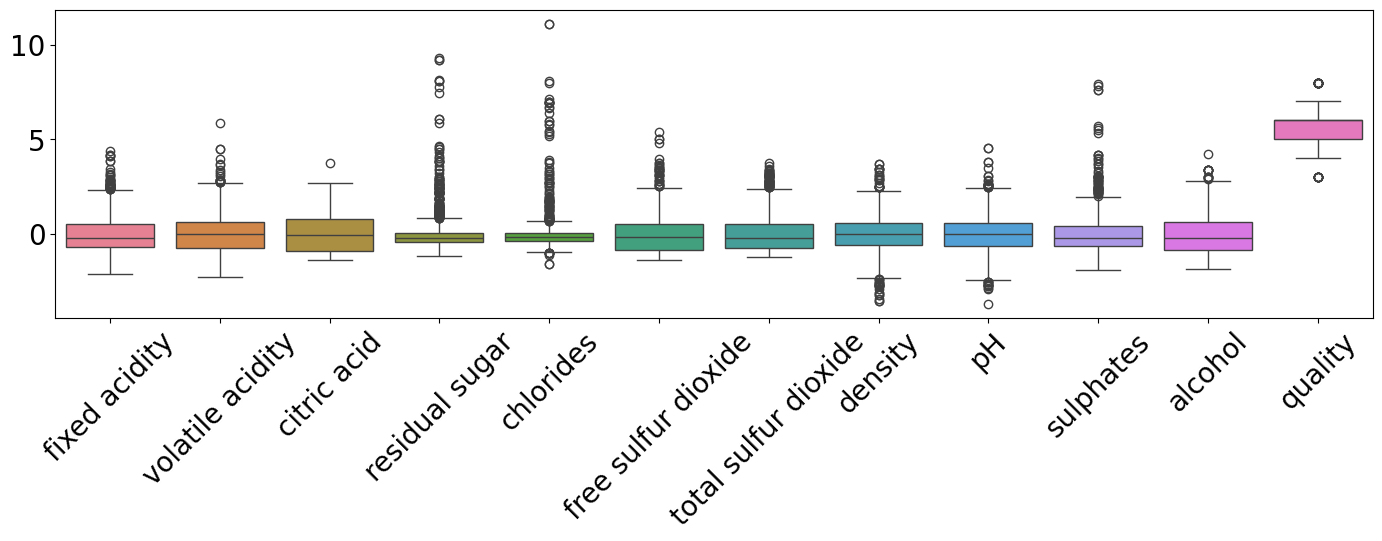

In [410]:
# plotting normalized data
fig, ax = plt.subplots(1, figsize=(17,4))
ax = sns.boxplot(data=data)
ax.tick_params(axis='x', rotation=45)
plt.show()

### Distribution of Quality Values
- In an ideal situation, all of the quality values are equally distributed through the entire dataset.

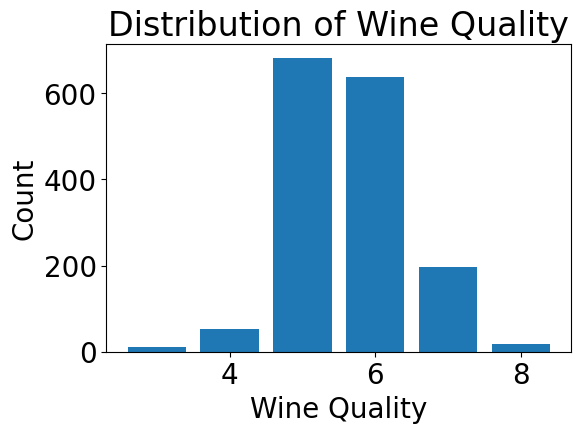

In [411]:
# plotting distribution of quality values
fig = plt.figure(figsize=(6,4))
plt.rcParams.update({'font.size': 20})

counts = data['quality'].value_counts()
plt.bar(list(counts.keys()), counts)
plt.xlabel('Wine Quality')
plt.ylabel('Count')
plt.title('Distribution of Wine Quality')
plt.show()

### This is not an even distribution! Next steps.
- **Binary categories** - Instead of having categories where each wine is predicted to be a 3 - 8 quality, there will be `good` (ratings $\gt 5$) or `bad` (ratings $\le 5$) wine. 
    - This simplifies the problem, and the model required to solve it.
- In this dataset, the wine qualities at 5 and 6 are over-represented compared to the rest of the qualities.
- The binary categories will be labeled in a new feature created, called `bool_quality`.

In [412]:
# creating a new column for boolean quality. Assigning 1 when rating is >5 in 'quality' feature, else 0.
data['bool_quality'] = np.where(data['quality']>5, 1, 0)

data[['quality', 'bool_quality']]

,quality,bool_quality
0,5,0
1,5,0
2,5,0
3,6,1
4,5,0
...,...,...
1594,5,0
1595,6,1
1596,6,1
1597,5,0


#### Loading Data

In [413]:
# converting to tensors
torch_data = torch.tensor(data[selected_columns].values).float() # excluding quality and bool_quality columns
labels = torch.tensor(data['bool_quality'].values).float() # binary quality values are used as the label for each wine

print(torch_data.shape)
print('labels array:',labels.shape)

# converting labels into a 1D tensor (from list)
labels = labels[:,None]
print('labels tensor:',labels.shape)
#print(labels)

torch.Size([1597, 11])
labels array: torch.Size([1597])
labels tensor: torch.Size([1597, 1])


In [414]:
# Partitioning Data into training and test sets
training_data, test_data, training_labels, test_labels = train_test_split(torch_data, labels, test_size=0.1)

# creating tensor datasets
training_data = TensorDataset(training_data, training_labels)
test_data = TensorDataset(test_data, test_labels)

#### The `create_data_loaders()` function will allow a data loader object to be created for each batch size.

In [415]:
# creates data loaders with specified 2^N batch size
def create_data_loaders(training_dataset, testing_dataset, batch_size):    
    
    train_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(testing_dataset, batch_size= test_data.tensors[0].shape[0])
    return train_loader, test_loader

---
## Model Architecture

In [416]:
def create_ANN_model(learning_rate=0.01):
    
    # model architecture
    ANN_model = nn.Sequential(
        nn.Linear(11, 12), # 11 input features in dataset
        nn.ReLU(),
        nn.Linear(12, 12),
        nn.ReLU(),
        nn.Linear(12, 1) # 1 classification (good or bad wine)
    )

    # loss function
    loss_function = nn.BCEWithLogitsLoss()

    # optimizer
    optimizer = torch.optim.SGD(ANN_model.parameters(), lr=learning_rate)

    return ANN_model, loss_function, optimizer

### Function to Train Model

In [417]:
def batch_train_model(number_of_epochs, model, loss_function, optimizer, train_loader, test_loader):
    
    training_accuracy_ary = []
    testing_accuracy_ary = []
    losses_ary = []

    # loop over epochs
    for epoch_IDX in range(number_of_epochs):

        batch_accuracy = []
        batch_loss = []
        
        for batch, labels in train_loader:
        # forward pass and calculate loss
            y_hat = model(batch)
            #print('Size of y hat',y_hat.size())
            #print(y_hat)

            #print('labels size', labels.shape)
            #print(labels)
            loss = loss_function(y_hat, labels)

            # back propagation (learning)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # calculate accuracy for current batch
            batch_accuracy.append(100*torch.mean((torch.argmax(y_hat, axis=1) == labels).float()).item())

            # batch losses
            batch_loss.append(loss.item())

        # calculate overall training accuracy and loss
        training_accuracy_ary.append(np.mean(batch_accuracy))
        losses_ary.append(np.mean(batch_loss))

        # Cross Validation of Model
        X_data, y_labels = next(iter(test_loader)) # there is only one batch, so there's no need for a for loop
        
        with torch.no_grad(): # disables gradient-related computations, appropriate when testing model
            predicted_testing_labels = torch.argmax(model(X_data),axis=1)

        # calculate testing accuracy
        testing_accuracy_ary.append(100*torch.mean((predicted_testing_labels == y_labels).float()).item())

    return training_accuracy_ary, testing_accuracy_ary, losses_ary

#### Quick Sanity Check

In [418]:
learning_rate = 0.0001
num_epochs = 1000
batch = 132

# Partitioning Data into training and test sets
training_data, test_data, training_labels, test_labels = train_test_split(torch_data, labels, test_size=0.1)

# creating tensor datasets
training_data = TensorDataset(training_data, training_labels)
test_data = TensorDataset(test_data, test_labels)


train_ldr, test_ldr = create_data_loaders(training_data, test_data, batch_size=batch)
test_model, test_loss, test_optimizer = create_ANN_model(learning_rate)

training_acc, test_acc, losses = batch_train_model(num_epochs, 
                                                   test_model, 
                                                   test_loss, 
                                                   test_optimizer, 
                                                   train_ldr, 
                                                   test_ldr)

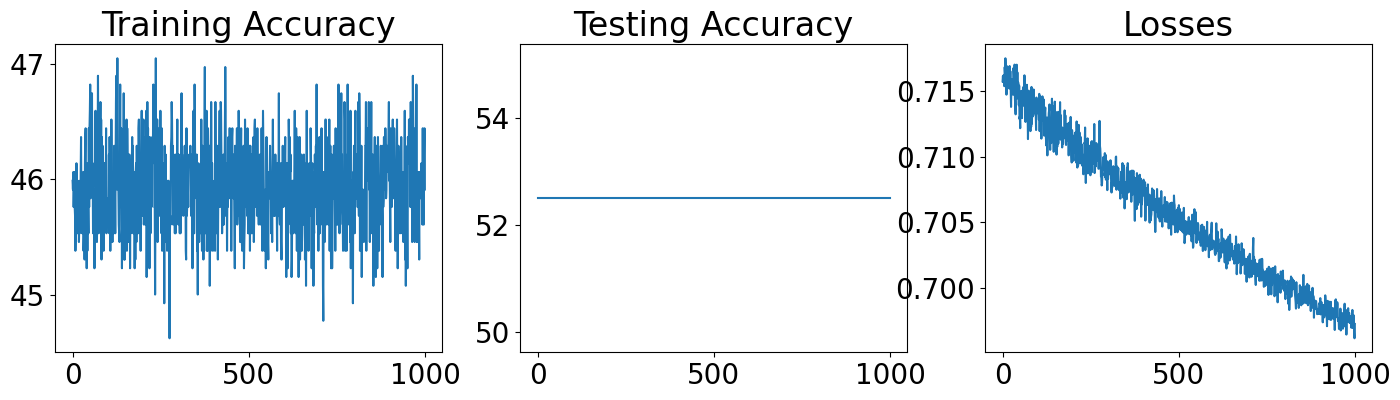

In [419]:
# plot results
fig, ax = plt.subplots(1, 3, figsize = (17,4))

ax[0].plot(training_acc)
ax[0].set_title('Training Accuracy')

ax[1].plot(test_acc)
ax[1].set_title('Testing Accuracy')

ax[2].plot(losses)
ax[2].set_title('Losses')

plt.show()